In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils & preprocess

X = (batch, sequence, dimension)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [2]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [3]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [4]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [6]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average='macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [9]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [10]:
class GRU(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.gru = nn.GRU(config.input_size, config.hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(config.hidden_size//2, config.output_size)
        )
        self.actv = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)
        gru_out, hidden = self.gru(x, hidden)
        last_output = gru_out[:, -1, :]
        output = self.actv(self.fc(last_output))

        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

# trainer 구현

In [11]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")
    
  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [12]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 4000    # healthy data를 몇개를 쓸지
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  input_size = 19        # 처음 input의 차원의 개수 (feature수와 같다)
  hidden_size=512        # GRU hidden vector size
  output_size = 2        # output 차원의 개수

config = Config()

In [13]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [14]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [15]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


In [16]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 4000
failure(1)의 개수 : 1569


In [17]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [18]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [19]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [20]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 3341
Total number of data samples in valid_loader: 1113
Total number of data samples in test_loader: 1114


In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [22]:
# model, optimizer, loss_function 구현하고 결합시키기
model = GRU(config)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [23]:
# save path 지정 잘해줄 것!!!!!!!!(일단 지금은 저장하지 말자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/4000_GRU') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 5/5 [00:00<00:00, 545.99it/s]


Model saved
TRAIN LOSS = 0.0025890749644747898, TRAIN ACC = 0.7000897934750074, 
VALID LOSS = 0.0025320780352226595, VALID ACC = 0.7601078167115903, 
epoch 2


100%|██████████| 5/5 [00:00<00:00, 515.64it/s]


TRAIN LOSS = 0.0021570522925768807, TRAIN ACC = 0.7605507333133792, 
VALID LOSS = 0.002312286309261956, VALID ACC = 0.7601078167115903, 
epoch 3


100%|██████████| 5/5 [00:00<00:00, 91.28it/s]


TRAIN LOSS = 0.0021274460179118546, TRAIN ACC = 0.7668362765639031, 
VALID LOSS = 0.0022519465940874757, VALID ACC = 0.7556154537286612, 
epoch 4


100%|██████████| 5/5 [00:00<00:00, 547.46it/s]


Model saved
TRAIN LOSS = 0.001966852256545975, TRAIN ACC = 0.7782101167315175, 
VALID LOSS = 0.0021478889337661344, VALID ACC = 0.7672955974842768, 
epoch 5


100%|██████████| 5/5 [00:00<00:00, 543.81it/s]


Model saved
TRAIN LOSS = 0.0018834500247152648, TRAIN ACC = 0.7838970368153247, 
VALID LOSS = 0.002106732595962977, VALID ACC = 0.7789757412398922, 
epoch 6


100%|██████████| 5/5 [00:00<00:00, 547.26it/s]


TRAIN LOSS = 0.0018902205218458133, TRAIN ACC = 0.7815025441484585, 
VALID LOSS = 0.002133336510619706, VALID ACC = 0.7637017070979335, 
epoch 7


100%|██████████| 5/5 [00:00<00:00, 548.52it/s]


TRAIN LOSS = 0.001863338024235885, TRAIN ACC = 0.7826997904818916, 
VALID LOSS = 0.0022907836525052493, VALID ACC = 0.7646001796945193, 
epoch 8


100%|██████████| 5/5 [00:00<00:00, 520.33it/s]


TRAIN LOSS = 0.0019031427321195675, TRAIN ACC = 0.7797066746483089, 
VALID LOSS = 0.0019954738591237853, VALID ACC = 0.7619047619047619, 
epoch 9


100%|██████████| 5/5 [00:00<00:00, 549.18it/s]


TRAIN LOSS = 0.0017848751727637686, TRAIN ACC = 0.7785094283148758, 
VALID LOSS = 0.001944579043478336, VALID ACC = 0.7744833782569631, 
epoch 10


100%|██████████| 5/5 [00:00<00:00, 549.27it/s]


TRAIN LOSS = 0.0017251497665874546, TRAIN ACC = 0.7934750074827895, 
VALID LOSS = 0.0019133570005737332, VALID ACC = 0.7780772686433064, 
epoch 11


100%|██████████| 5/5 [00:00<00:00, 497.44it/s]


Model saved
TRAIN LOSS = 0.0016247352077303728, TRAIN ACC = 0.7952708769829392, 
VALID LOSS = 0.0019637544682083747, VALID ACC = 0.7825696316262354, 
epoch 12


100%|██████████| 5/5 [00:00<00:00, 537.58it/s]


TRAIN LOSS = 0.0016188030826656521, TRAIN ACC = 0.7934750074827895, 
VALID LOSS = 0.0018279685807035297, VALID ACC = 0.7789757412398922, 
epoch 13


100%|██████████| 5/5 [00:00<00:00, 545.58it/s]


TRAIN LOSS = 0.0016204638596745674, TRAIN ACC = 0.7958695001496557, 
VALID LOSS = 0.001853258783283902, VALID ACC = 0.7825696316262354, 
epoch 14


100%|██████████| 5/5 [00:00<00:00, 485.95it/s]


Model saved
TRAIN LOSS = 0.0016778552382337017, TRAIN ACC = 0.7940736306495061, 
VALID LOSS = 0.0017804198723490562, VALID ACC = 0.7870619946091644, 
epoch 15


100%|██████████| 5/5 [00:00<00:00, 548.43it/s]


TRAIN LOSS = 0.0017247224096693845, TRAIN ACC = 0.803651601316971, 
VALID LOSS = 0.00172925383682628, VALID ACC = 0.779874213836478, 
epoch 16


100%|██████████| 5/5 [00:00<00:00, 548.22it/s]


TRAIN LOSS = 0.0016826645712836779, TRAIN ACC = 0.8012571086501048, 
VALID LOSS = 0.001969165504246495, VALID ACC = 0.7861635220125787, 
epoch 17


100%|██████████| 5/5 [00:00<00:00, 550.36it/s]


TRAIN LOSS = 0.0016739848166017323, TRAIN ACC = 0.7931756958994313, 
VALID LOSS = 0.001856752697241167, VALID ACC = 0.7789757412398922, 
epoch 18


100%|██████████| 5/5 [00:00<00:00, 546.70it/s]


Model saved
TRAIN LOSS = 0.001576638969251832, TRAIN ACC = 0.7943729422328644, 
VALID LOSS = 0.0017289096775723275, VALID ACC = 0.7879604672057502, 
epoch 19


100%|██████████| 5/5 [00:00<00:00, 540.68it/s]


Model saved
TRAIN LOSS = 0.0014883498211029724, TRAIN ACC = 0.8006584854833882, 
VALID LOSS = 0.001676446799212282, VALID ACC = 0.7897574123989218, 
epoch 20


100%|██████████| 5/5 [00:00<00:00, 546.03it/s]


TRAIN LOSS = 0.0015912190931566244, TRAIN ACC = 0.8111343909009279, 
VALID LOSS = 0.0017196914952613165, VALID ACC = 0.7852650494159928, 
epoch 21


100%|██████████| 5/5 [00:00<00:00, 527.43it/s]


TRAIN LOSS = 0.0015718082188489514, TRAIN ACC = 0.7985633043998803, 
VALID LOSS = 0.001654871658280639, VALID ACC = 0.788858939802336, 
epoch 22


100%|██████████| 5/5 [00:00<00:00, 515.33it/s]


TRAIN LOSS = 0.0014887459975307983, TRAIN ACC = 0.8012571086501048, 
VALID LOSS = 0.0016192546162858057, VALID ACC = 0.7852650494159928, 
epoch 23


100%|██████████| 5/5 [00:00<00:00, 521.87it/s]


Model saved
TRAIN LOSS = 0.001372477593303476, TRAIN ACC = 0.8108350793175696, 
VALID LOSS = 0.0014769056442077376, VALID ACC = 0.7942497753818508, 
epoch 24


100%|██████████| 5/5 [00:00<00:00, 536.33it/s]


TRAIN LOSS = 0.0013822662022184447, TRAIN ACC = 0.8153247530679437, 
VALID LOSS = 0.0016829526488671726, VALID ACC = 0.784366576819407, 
epoch 25


100%|██████████| 5/5 [00:00<00:00, 485.56it/s]


TRAIN LOSS = 0.0013852625755234702, TRAIN ACC = 0.7949715653995809, 
VALID LOSS = 0.0014985522919695117, VALID ACC = 0.7924528301886793, 
epoch 26


100%|██████████| 5/5 [00:00<00:00, 547.75it/s]


Model saved
TRAIN LOSS = 0.0013276021643264392, TRAIN ACC = 0.8093385214007782, 
VALID LOSS = 0.0015899838623653524, VALID ACC = 0.8005390835579514, 
epoch 27


100%|██████████| 5/5 [00:00<00:00, 539.63it/s]


TRAIN LOSS = 0.0012755243855299117, TRAIN ACC = 0.8165219994013768, 
VALID LOSS = 0.0015784194366629876, VALID ACC = 0.7978436657681941, 
epoch 28


100%|██████████| 5/5 [00:00<00:00, 547.73it/s]


TRAIN LOSS = 0.001315539453565557, TRAIN ACC = 0.8168213109847351, 
VALID LOSS = 0.001540583152548215, VALID ACC = 0.7942497753818508, 
epoch 29


100%|██████████| 5/5 [00:00<00:00, 551.16it/s]


Model saved
TRAIN LOSS = 0.0012757399416869002, TRAIN ACC = 0.8201137384016761, 
VALID LOSS = 0.001355517558545972, VALID ACC = 0.8023360287511231, 
epoch 30


100%|██████████| 5/5 [00:00<00:00, 531.89it/s]


Model saved
TRAIN LOSS = 0.001285787124328362, TRAIN ACC = 0.822208919485184, 
VALID LOSS = 0.0013937316868397318, VALID ACC = 0.8104222821203954, 
epoch 31


100%|██████████| 5/5 [00:00<00:00, 540.20it/s]


TRAIN LOSS = 0.001206805038081069, TRAIN ACC = 0.8263992816521999, 
VALID LOSS = 0.0013356094599198567, VALID ACC = 0.8077268643306379, 
epoch 32


100%|██████████| 5/5 [00:00<00:00, 545.47it/s]


Model saved
TRAIN LOSS = 0.0010685265104380312, TRAIN ACC = 0.831786890152649, 
VALID LOSS = 0.001311373825771575, VALID ACC = 0.8140161725067385, 
epoch 33


100%|██████████| 5/5 [00:00<00:00, 533.07it/s]


TRAIN LOSS = 0.001166612529818864, TRAIN ACC = 0.8353786291529482, 
VALID LOSS = 0.0014256369071508031, VALID ACC = 0.8059299191374663, 
epoch 34


100%|██████████| 5/5 [00:00<00:00, 541.28it/s]


TRAIN LOSS = 0.0011386112810358676, TRAIN ACC = 0.822208919485184, 
VALID LOSS = 0.001446161790678122, VALID ACC = 0.7960467205750225, 
epoch 35


100%|██████████| 5/5 [00:00<00:00, 544.67it/s]


TRAIN LOSS = 0.001009513245183563, TRAIN ACC = 0.831786890152649, 
VALID LOSS = 0.001278404598287495, VALID ACC = 0.8032345013477089, 
epoch 36


100%|██████████| 5/5 [00:00<00:00, 548.25it/s]


TRAIN LOSS = 0.001041395021605299, TRAIN ACC = 0.8335827596527986, 
VALID LOSS = 0.001219194747259889, VALID ACC = 0.8131176999101527, 
epoch 37


100%|██████████| 5/5 [00:00<00:00, 547.53it/s]


Model saved
TRAIN LOSS = 0.0009442411365354893, TRAIN ACC = 0.8359772523196648, 
VALID LOSS = 0.0012074294838943893, VALID ACC = 0.8149146451033243, 
epoch 38


100%|██████████| 5/5 [00:00<00:00, 549.04it/s]


TRAIN LOSS = 0.001038290624916821, TRAIN ACC = 0.84375935348698, 
VALID LOSS = 0.0014963798552938977, VALID ACC = 0.8122192273135669, 
epoch 39


100%|██████████| 5/5 [00:00<00:00, 538.84it/s]


Model saved
TRAIN LOSS = 0.0009801992262883374, TRAIN ACC = 0.8527387009877282, 
VALID LOSS = 0.0013400118359551169, VALID ACC = 0.816711590296496, 
epoch 40


100%|██████████| 5/5 [00:00<00:00, 534.37it/s]


Model saved
TRAIN LOSS = 0.0009345911070815962, TRAIN ACC = 0.8554325052379527, 
VALID LOSS = 0.001271983201934321, VALID ACC = 0.8310871518418689, 
epoch 41


100%|██████████| 5/5 [00:00<00:00, 534.07it/s]


TRAIN LOSS = 0.0009354162594402168, TRAIN ACC = 0.8545345704878778, 
VALID LOSS = 0.0013057563423789094, VALID ACC = 0.8131176999101527, 
epoch 42


100%|██████████| 5/5 [00:00<00:00, 216.04it/s]


TRAIN LOSS = 0.0008881149517494345, TRAIN ACC = 0.8479497156539958, 
VALID LOSS = 0.0012964730260614221, VALID ACC = 0.8221024258760108, 
epoch 43


100%|██████████| 5/5 [00:00<00:00, 547.87it/s]


TRAIN LOSS = 0.0008539382487633599, TRAIN ACC = 0.8623166716551931, 
VALID LOSS = 0.00123961631339194, VALID ACC = 0.8203054806828391, 
epoch 44


100%|██████████| 5/5 [00:00<00:00, 548.30it/s]


TRAIN LOSS = 0.0009888546288780594, TRAIN ACC = 0.8395689913199641, 
VALID LOSS = 0.001217914653167142, VALID ACC = 0.8247978436657682, 
epoch 45


100%|██████████| 5/5 [00:00<00:00, 538.34it/s]


Model saved
TRAIN LOSS = 0.0009008565506725317, TRAIN ACC = 0.8524393894043699, 
VALID LOSS = 0.001211442341166151, VALID ACC = 0.8337825696316262, 
epoch 46


100%|██████████| 5/5 [00:00<00:00, 545.47it/s]


Model saved
TRAIN LOSS = 0.0007873592606671233, TRAIN ACC = 0.8659084106554924, 
VALID LOSS = 0.0011820773203310834, VALID ACC = 0.8436657681940701, 
epoch 47


100%|██████████| 5/5 [00:00<00:00, 546.26it/s]


Model saved
TRAIN LOSS = 0.000734018466851555, TRAIN ACC = 0.8808739898234061, 
VALID LOSS = 0.0013176250971873816, VALID ACC = 0.8562443845462714, 
epoch 48


100%|██████████| 5/5 [00:00<00:00, 538.80it/s]


TRAIN LOSS = 0.0008002137021010809, TRAIN ACC = 0.881771924573481, 
VALID LOSS = 0.0011840281273369734, VALID ACC = 0.834681042228212, 
epoch 49


100%|██████████| 5/5 [00:00<00:00, 543.74it/s]


TRAIN LOSS = 0.0009011002767589127, TRAIN ACC = 0.8712960191559413, 
VALID LOSS = 0.0013677604489784891, VALID ACC = 0.8050314465408805, 
epoch 50


100%|██████████| 5/5 [00:00<00:00, 549.21it/s]


TRAIN LOSS = 0.0013177867636499346, TRAIN ACC = 0.8153247530679437, 
VALID LOSS = 0.001725237324552716, VALID ACC = 0.7951482479784366, 
epoch 51


100%|██████████| 5/5 [00:00<00:00, 539.27it/s]


TRAIN LOSS = 0.0013464403229179371, TRAIN ACC = 0.8168213109847351, 
VALID LOSS = 0.001442671571887514, VALID ACC = 0.7960467205750225, 
epoch 52


100%|██████████| 5/5 [00:00<00:00, 548.71it/s]


TRAIN LOSS = 0.001248901487467211, TRAIN ACC = 0.8293923974857828, 
VALID LOSS = 0.0013266456416353705, VALID ACC = 0.8059299191374663, 
epoch 53


100%|██████████| 5/5 [00:00<00:00, 547.22it/s]


TRAIN LOSS = 0.0010730681778677422, TRAIN ACC = 0.8356779407363065, 
VALID LOSS = 0.001309397781848479, VALID ACC = 0.8238993710691824, 
epoch 54


100%|██████████| 5/5 [00:00<00:00, 549.71it/s]


TRAIN LOSS = 0.0011535226379958002, TRAIN ACC = 0.8371744986530979, 
VALID LOSS = 0.0014024421050542128, VALID ACC = 0.8032345013477089, 
epoch 55


100%|██████████| 5/5 [00:00<00:00, 547.54it/s]


TRAIN LOSS = 0.0010688060878440671, TRAIN ACC = 0.8284944627357079, 
VALID LOSS = 0.0012627351905243522, VALID ACC = 0.8203054806828391, 
epoch 56


100%|██████████| 5/5 [00:00<00:00, 552.10it/s]


TRAIN LOSS = 0.0009249043086445, TRAIN ACC = 0.8581263094881771, 
VALID LOSS = 0.0012540845376140667, VALID ACC = 0.8382749326145552, 
epoch 57


100%|██████████| 5/5 [00:00<00:00, 544.12it/s]


TRAIN LOSS = 0.0008757116105234648, TRAIN ACC = 0.8662077222388507, 
VALID LOSS = 0.0013269184681068962, VALID ACC = 0.8400718778077269, 
epoch 58


100%|██████████| 5/5 [00:00<00:00, 551.36it/s]


TRAIN LOSS = 0.0008209994750192728, TRAIN ACC = 0.8793774319066148, 
VALID LOSS = 0.0012716295503863106, VALID ACC = 0.8364779874213837, 
epoch 59


100%|██████████| 5/5 [00:00<00:00, 527.00it/s]


TRAIN LOSS = 0.0007590096141720417, TRAIN ACC = 0.87847949715654, 
VALID LOSS = 0.0012302587322576134, VALID ACC = 0.8427672955974843, 
epoch 60


100%|██████████| 5/5 [00:00<00:00, 547.32it/s]


TRAIN LOSS = 0.0007401618373961336, TRAIN ACC = 0.8859622867404968, 
VALID LOSS = 0.0011528244933242317, VALID ACC = 0.8508535489667565, 
epoch 61


100%|██████████| 5/5 [00:00<00:00, 543.75it/s]


Model saved
TRAIN LOSS = 0.0006743927191596159, TRAIN ACC = 0.8937443879078121, 
VALID LOSS = 0.0012235373579909537, VALID ACC = 0.8589398023360287, 
epoch 62


100%|██████████| 5/5 [00:00<00:00, 529.48it/s]


TRAIN LOSS = 0.0007500344855597689, TRAIN ACC = 0.8811733014067644, 
VALID LOSS = 0.001229865089902338, VALID ACC = 0.8535489667565139, 
epoch 63


100%|██████████| 5/5 [00:00<00:00, 542.18it/s]


TRAIN LOSS = 0.0006244923322623503, TRAIN ACC = 0.8904519604908709, 
VALID LOSS = 0.0012547917068272375, VALID ACC = 0.8463611859838275, 
epoch 64


100%|██████████| 5/5 [00:00<00:00, 532.75it/s]


TRAIN LOSS = 0.0006087389589248037, TRAIN ACC = 0.9009278659084107, 
VALID LOSS = 0.001348744652770386, VALID ACC = 0.8445642407906558, 
epoch 65


100%|██████████| 5/5 [00:00<00:00, 546.30it/s]


Model saved
TRAIN LOSS = 0.000506369704232891, TRAIN ACC = 0.9066147859922179, 
VALID LOSS = 0.0012981834865751721, VALID ACC = 0.8607367475292004, 
epoch 66


100%|██████████| 5/5 [00:00<00:00, 534.54it/s]


TRAIN LOSS = 0.00046006455042964505, TRAIN ACC = 0.9114037713259503, 
VALID LOSS = 0.001425909813952039, VALID ACC = 0.8490566037735849, 
epoch 67


100%|██████████| 5/5 [00:00<00:00, 546.57it/s]


TRAIN LOSS = 0.00046256037785224807, TRAIN ACC = 0.9134989524094582, 
VALID LOSS = 0.0014076939276072321, VALID ACC = 0.8535489667565139, 
epoch 68


100%|██████████| 5/5 [00:00<00:00, 539.56it/s]


Model saved
TRAIN LOSS = 0.0005568576961604109, TRAIN ACC = 0.9102065249925172, 
VALID LOSS = 0.0011576847620944342, VALID ACC = 0.8616352201257862, 
epoch 69


100%|██████████| 5/5 [00:00<00:00, 547.14it/s]


Model saved
TRAIN LOSS = 0.00047684943835575507, TRAIN ACC = 0.9155941334929661, 
VALID LOSS = 0.0012764808757821397, VALID ACC = 0.8643306379155435, 
epoch 70


100%|██████████| 5/5 [00:00<00:00, 544.96it/s]


TRAIN LOSS = 0.0004765506286315667, TRAIN ACC = 0.9233762346602814, 
VALID LOSS = 0.0012185517614849602, VALID ACC = 0.8643306379155435, 
epoch 71


100%|██████████| 5/5 [00:00<00:00, 147.79it/s]


Model saved
TRAIN LOSS = 0.00044504531225163365, TRAIN ACC = 0.9212810535767734, 
VALID LOSS = 0.001272731366076131, VALID ACC = 0.8679245283018868, 
epoch 72


100%|██████████| 5/5 [00:00<00:00, 542.57it/s]


Model saved
TRAIN LOSS = 0.0003800089979771189, TRAIN ACC = 0.9254714157437893, 
VALID LOSS = 0.0014201191397047429, VALID ACC = 0.8733153638814016, 
epoch 73


100%|██████████| 5/5 [00:00<00:00, 545.30it/s]


TRAIN LOSS = 0.00037853707679550433, TRAIN ACC = 0.9317569589943131, 
VALID LOSS = 0.0015159609450591327, VALID ACC = 0.8733153638814016, 
epoch 74


100%|██████████| 5/5 [00:00<00:00, 503.99it/s]


TRAIN LOSS = 0.000613951283420356, TRAIN ACC = 0.9224782999102066, 
VALID LOSS = 0.001342924363636692, VALID ACC = 0.8580413297394429, 
epoch 75


100%|██████████| 5/5 [00:00<00:00, 537.03it/s]


TRAIN LOSS = 0.0005720425241054513, TRAIN ACC = 0.9114037713259503, 
VALID LOSS = 0.0012998798893896824, VALID ACC = 0.8598382749326146, 
epoch 76


100%|██████████| 5/5 [00:00<00:00, 549.42it/s]


TRAIN LOSS = 0.00047880323507299826, TRAIN ACC = 0.9257707273271476, 
VALID LOSS = 0.0013932426261773327, VALID ACC = 0.8706199460916442, 
epoch 77


100%|██████████| 5/5 [00:00<00:00, 529.01it/s]


Model saved
TRAIN LOSS = 0.00043129698289471875, TRAIN ACC = 0.9329542053277462, 
VALID LOSS = 0.0015751325591448076, VALID ACC = 0.8769092542677448, 
epoch 78


100%|██████████| 5/5 [00:00<00:00, 543.49it/s]


Model saved
TRAIN LOSS = 0.000402796170564156, TRAIN ACC = 0.9536067045794673, 
VALID LOSS = 0.0012871441092452592, VALID ACC = 0.9065588499550764, 
epoch 79


100%|██████████| 5/5 [00:00<00:00, 545.82it/s]


Model saved
TRAIN LOSS = 0.00028515881860159854, TRAIN ACC = 0.9736605806644717, 
VALID LOSS = 0.0012771128563868067, VALID ACC = 0.9083557951482479, 
epoch 80


100%|██████████| 5/5 [00:00<00:00, 546.67it/s]


Model saved
TRAIN LOSS = 0.00022832406431088652, TRAIN ACC = 0.9802454354983537, 
VALID LOSS = 0.001169705166006988, VALID ACC = 0.917340521114106, 
epoch 81


100%|██████████| 5/5 [00:00<00:00, 412.48it/s]


TRAIN LOSS = 0.00017661019597750016, TRAIN ACC = 0.984735109248728, 
VALID LOSS = 0.0014025737386722341, VALID ACC = 0.9164420485175202, 
epoch 82


100%|██████████| 5/5 [00:00<00:00, 544.56it/s]


TRAIN LOSS = 0.0001441504360201432, TRAIN ACC = 0.9862316671655194, 
VALID LOSS = 0.0013410089150914606, VALID ACC = 0.9155435759209344, 
epoch 83


100%|██████████| 5/5 [00:00<00:00, 548.10it/s]


Model saved
TRAIN LOSS = 0.00012915566718594396, TRAIN ACC = 0.988027536665669, 
VALID LOSS = 0.0013416088709184315, VALID ACC = 0.9209344115004492, 
epoch 84


100%|██████████| 5/5 [00:00<00:00, 542.19it/s]


TRAIN LOSS = 0.000144037368727708, TRAIN ACC = 0.9871296019155942, 
VALID LOSS = 0.0014542042138013128, VALID ACC = 0.912848158131177, 
epoch 85


100%|██████████| 5/5 [00:00<00:00, 545.91it/s]


TRAIN LOSS = 0.00023087565108366584, TRAIN ACC = 0.9769530080814127, 
VALID LOSS = 0.0013252809737463417, VALID ACC = 0.9146451033243486, 
epoch 86


100%|██████████| 5/5 [00:00<00:00, 518.03it/s]


Model saved
TRAIN LOSS = 0.00021366422632985115, TRAIN ACC = 0.9841364860820113, 
VALID LOSS = 0.00118078561859525, VALID ACC = 0.9299191374663073, 
epoch 87


100%|██████████| 5/5 [00:00<00:00, 539.57it/s]


TRAIN LOSS = 0.0002503036655177884, TRAIN ACC = 0.9808440586650703, 
VALID LOSS = 0.0012381847710193864, VALID ACC = 0.917340521114106, 
epoch 88


100%|██████████| 5/5 [00:00<00:00, 527.76it/s]


TRAIN LOSS = 0.00016915993260448832, TRAIN ACC = 0.9841364860820113, 
VALID LOSS = 0.001225979461502836, VALID ACC = 0.921832884097035, 
epoch 89


100%|██████████| 5/5 [00:00<00:00, 542.00it/s]


Model saved
TRAIN LOSS = 0.00010945492144478934, TRAIN ACC = 0.9931158335827597, 
VALID LOSS = 0.0011107870724858834, VALID ACC = 0.9308176100628931, 
epoch 90


100%|██████████| 5/5 [00:00<00:00, 538.80it/s]


Model saved
TRAIN LOSS = 8.795230848164446e-05, TRAIN ACC = 0.9952110146662676, 
VALID LOSS = 0.0011737826351421114, VALID ACC = 0.9326145552560647, 
epoch 91


100%|██████████| 5/5 [00:00<00:00, 547.30it/s]


TRAIN LOSS = 0.0007674757419647445, TRAIN ACC = 0.9524094582460341, 
VALID LOSS = 0.0020310979433565235, VALID ACC = 0.8607367475292004, 
epoch 92


100%|██████████| 5/5 [00:00<00:00, 548.82it/s]


TRAIN LOSS = 0.0010370378168140903, TRAIN ACC = 0.8865609099072134, 
VALID LOSS = 0.001227656304032976, VALID ACC = 0.8840970350404312, 
epoch 93


100%|██████████| 5/5 [00:00<00:00, 533.74it/s]


TRAIN LOSS = 0.0007156363524779771, TRAIN ACC = 0.9185872493265489, 
VALID LOSS = 0.0010907665925955622, VALID ACC = 0.8966756513926325, 
epoch 94


100%|██████████| 5/5 [00:00<00:00, 543.26it/s]


TRAIN LOSS = 0.000548638523838114, TRAIN ACC = 0.9443280454953606, 
VALID LOSS = 0.0010672499093512427, VALID ACC = 0.9101527403414196, 
epoch 95


100%|██████████| 5/5 [00:00<00:00, 544.74it/s]


TRAIN LOSS = 0.0004023129041860004, TRAIN ACC = 0.9604908709967076, 
VALID LOSS = 0.0010399703548924942, VALID ACC = 0.9119496855345912, 
epoch 96


100%|██████████| 5/5 [00:00<00:00, 535.93it/s]


TRAIN LOSS = 0.0002862135051791181, TRAIN ACC = 0.97395989224783, 
VALID LOSS = 0.0011066889184504507, VALID ACC = 0.9200359389038635, 
epoch 97


100%|██████████| 5/5 [00:00<00:00, 545.17it/s]


TRAIN LOSS = 0.00025475395643240103, TRAIN ACC = 0.9781502544148458, 
VALID LOSS = 0.0011123132834216013, VALID ACC = 0.9209344115004492, 
epoch 98


100%|██████████| 5/5 [00:00<00:00, 533.17it/s]


TRAIN LOSS = 0.00024307191269335652, TRAIN ACC = 0.9790481891649206, 
VALID LOSS = 0.001060978916991646, VALID ACC = 0.9110512129380054, 
epoch 99


100%|██████████| 5/5 [00:00<00:00, 540.25it/s]


TRAIN LOSS = 0.00019331345987216026, TRAIN ACC = 0.983837174498653, 
VALID LOSS = 0.0010671268442356146, VALID ACC = 0.917340521114106, 
epoch 100


100%|██████████| 5/5 [00:00<00:00, 542.97it/s]


TRAIN LOSS = 0.00019198905345441623, TRAIN ACC = 0.9850344208320863, 
VALID LOSS = 0.0011039875541468086, VALID ACC = 0.9155435759209344, 
epoch 101


100%|██████████| 5/5 [00:00<00:00, 546.73it/s]


TRAIN LOSS = 0.00027978948994286846, TRAIN ACC = 0.9745585154145465, 
VALID LOSS = 0.0013519399410309497, VALID ACC = 0.9047619047619048, 
epoch 102


100%|██████████| 5/5 [00:00<00:00, 541.12it/s]


TRAIN LOSS = 0.00023286391090879323, TRAIN ACC = 0.9790481891649206, 
VALID LOSS = 0.001547600474854578, VALID ACC = 0.9119496855345912, 
epoch 103


100%|██████████| 5/5 [00:00<00:00, 548.39it/s]


TRAIN LOSS = 0.0003067669457293527, TRAIN ACC = 0.9790481891649206, 
VALID LOSS = 0.001260075246227398, VALID ACC = 0.9119496855345912, 
epoch 104


100%|██████████| 5/5 [00:00<00:00, 547.39it/s]


TRAIN LOSS = 0.0004927863145848657, TRAIN ACC = 0.9676743489973062, 
VALID LOSS = 0.0012994298957428843, VALID ACC = 0.9029649595687331, 
epoch 105


100%|██████████| 5/5 [00:00<00:00, 547.65it/s]


TRAIN LOSS = 0.0003151865829361017, TRAIN ACC = 0.9748578269979048, 
VALID LOSS = 0.0011876311290403368, VALID ACC = 0.9182389937106918, 
epoch 106


100%|██████████| 5/5 [00:00<00:00, 547.13it/s]


TRAIN LOSS = 0.00023281047066611753, TRAIN ACC = 0.983837174498653, 
VALID LOSS = 0.0010898909050392226, VALID ACC = 0.9263252470799641, 
epoch 107


100%|██████████| 5/5 [00:00<00:00, 553.47it/s]


TRAIN LOSS = 0.00015149692797392775, TRAIN ACC = 0.9892247829991021, 
VALID LOSS = 0.0011643848489879599, VALID ACC = 0.9254267744833783, 
epoch 108


100%|██████████| 5/5 [00:00<00:00, 549.11it/s]


TRAIN LOSS = 0.00017363359703966973, TRAIN ACC = 0.9928165219994014, 
VALID LOSS = 0.0012760416730930434, VALID ACC = 0.9245283018867925, 
epoch 109


100%|██████████| 5/5 [00:00<00:00, 549.52it/s]


Model saved
TRAIN LOSS = 0.00012898816334335115, TRAIN ACC = 0.988027536665669, 
VALID LOSS = 0.0010639748938535637, VALID ACC = 0.9371069182389937, 
epoch 110


100%|██████████| 5/5 [00:00<00:00, 538.89it/s]


TRAIN LOSS = 8.414179052955748e-05, TRAIN ACC = 0.993415145166118, 
VALID LOSS = 0.0010746124753626422, VALID ACC = 0.9353099730458221, 
epoch 111


100%|██████████| 5/5 [00:00<00:00, 538.66it/s]


TRAIN LOSS = 6.073266164636905e-05, TRAIN ACC = 0.9976055073331338, 
VALID LOSS = 0.0011742219449374874, VALID ACC = 0.9290206648697215, 
epoch 112


100%|██████████| 5/5 [00:00<00:00, 548.22it/s]


TRAIN LOSS = 5.38736462216201e-05, TRAIN ACC = 0.9976055073331338, 
VALID LOSS = 0.0012495017142737114, VALID ACC = 0.9344115004492363, 
epoch 113


100%|██████████| 5/5 [00:00<00:00, 547.72it/s]


Model saved
TRAIN LOSS = 4.663757386521053e-05, TRAIN ACC = 0.996707572583059, 
VALID LOSS = 0.001200485997979746, VALID ACC = 0.9389038634321654, 
epoch 114


100%|██████████| 5/5 [00:00<00:00, 537.14it/s]


TRAIN LOSS = 3.716188195046605e-05, TRAIN ACC = 0.9976055073331338, 
VALID LOSS = 0.001284989104116702, VALID ACC = 0.9380053908355795, 
epoch 115


100%|██████████| 5/5 [00:00<00:00, 545.25it/s]


TRAIN LOSS = 2.9616222194863155e-05, TRAIN ACC = 0.9979048189164921, 
VALID LOSS = 0.0013227751152213372, VALID ACC = 0.9362084456424079, 
epoch 116


100%|██████████| 5/5 [00:00<00:00, 544.93it/s]


TRAIN LOSS = 2.3611246283308e-05, TRAIN ACC = 0.9982041304998504, 
VALID LOSS = 0.0013569834418695249, VALID ACC = 0.9362084456424079, 
epoch 117


100%|██████████| 5/5 [00:00<00:00, 545.74it/s]


TRAIN LOSS = 1.3600622338767725e-05, TRAIN ACC = 0.9991020652499252, 
VALID LOSS = 0.0014792029400291682, VALID ACC = 0.9380053908355795, 
epoch 118


100%|██████████| 5/5 [00:00<00:00, 541.68it/s]


TRAIN LOSS = 9.266245290729005e-06, TRAIN ACC = 0.9997006884166417, 
VALID LOSS = 0.0015056382827895885, VALID ACC = 0.9335130278526504, 
epoch 119


100%|██████████| 5/5 [00:00<00:00, 538.21it/s]


TRAIN LOSS = 7.545414553000181e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0014470009549930089, VALID ACC = 0.9371069182389937, 
epoch 120


100%|██████████| 5/5 [00:00<00:00, 544.55it/s]


TRAIN LOSS = 6.347834805806609e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0014944751709297982, VALID ACC = 0.9344115004492363, 
epoch 121


100%|██████████| 5/5 [00:00<00:00, 535.94it/s]


TRAIN LOSS = 7.87255413391519e-06, TRAIN ACC = 0.9994013768332835, 
VALID LOSS = 0.0013747807756996808, VALID ACC = 0.9371069182389937, 
epoch 122


100%|██████████| 5/5 [00:00<00:00, 545.82it/s]


TRAIN LOSS = 4.102216524218896e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015731747366775828, VALID ACC = 0.9344115004492363, 
epoch 123


100%|██████████| 5/5 [00:00<00:00, 544.94it/s]


TRAIN LOSS = 2.949854222841174e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016088032792092226, VALID ACC = 0.9371069182389937, 
epoch 124


100%|██████████| 5/5 [00:00<00:00, 543.81it/s]


TRAIN LOSS = 2.3199663227567585e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0014661048728929161, VALID ACC = 0.9380053908355795, 
epoch 125


100%|██████████| 5/5 [00:00<00:00, 544.26it/s]


TRAIN LOSS = 2.009530535145626e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015281287272128562, VALID ACC = 0.9353099730458221, 
epoch 126


100%|██████████| 5/5 [00:00<00:00, 537.51it/s]


TRAIN LOSS = 1.8115928187864321e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016020790800144302, VALID ACC = 0.9380053908355795, 
epoch 127


100%|██████████| 5/5 [00:00<00:00, 530.80it/s]


TRAIN LOSS = 1.6303084170057215e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016694032760321933, VALID ACC = 0.9389038634321654, 
epoch 128


100%|██████████| 5/5 [00:00<00:00, 544.59it/s]


TRAIN LOSS = 1.6597599080052652e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018603050108975585, VALID ACC = 0.9389038634321654, 
epoch 129


100%|██████████| 5/5 [00:00<00:00, 521.61it/s]


TRAIN LOSS = 1.1697542100429574e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017446980000827511, VALID ACC = 0.9389038634321654, 
epoch 130


100%|██████████| 5/5 [00:00<00:00, 543.66it/s]


TRAIN LOSS = 9.400925835197434e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016652285276183329, VALID ACC = 0.9380053908355795, 
epoch 131


100%|██████████| 5/5 [00:00<00:00, 544.43it/s]


TRAIN LOSS = 8.843310734976849e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018179179148318418, VALID ACC = 0.9380053908355795, 
epoch 132


100%|██████████| 5/5 [00:00<00:00, 546.92it/s]


TRAIN LOSS = 9.897711675082252e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016546568298596899, VALID ACC = 0.9380053908355795, 
epoch 133


100%|██████████| 5/5 [00:00<00:00, 497.91it/s]


TRAIN LOSS = 8.427208540802256e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001702067023017657, VALID ACC = 0.9389038634321654, 
epoch 134


100%|██████████| 5/5 [00:00<00:00, 547.29it/s]


Model saved
TRAIN LOSS = 1.4460346310903184e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016709645776628698, VALID ACC = 0.9407008086253369, 
epoch 135


100%|██████████| 5/5 [00:00<00:00, 514.02it/s]


TRAIN LOSS = 9.259871656392344e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018126186441968178, VALID ACC = 0.9407008086253369, 
epoch 136


100%|██████████| 5/5 [00:00<00:00, 543.04it/s]


TRAIN LOSS = 7.528613619891041e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018219270367720913, VALID ACC = 0.9389038634321654, 
epoch 137


100%|██████████| 5/5 [00:00<00:00, 521.10it/s]


TRAIN LOSS = 5.652817084716866e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0021073039678014944, VALID ACC = 0.9389038634321654, 
epoch 138


100%|██████████| 5/5 [00:00<00:00, 537.44it/s]


TRAIN LOSS = 6.602826740175142e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017780220840604908, VALID ACC = 0.9398023360287511, 
epoch 139


100%|██████████| 5/5 [00:00<00:00, 545.62it/s]


TRAIN LOSS = 6.834366418574863e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016840307806808457, VALID ACC = 0.9389038634321654, 
epoch 140


100%|██████████| 5/5 [00:00<00:00, 546.42it/s]


TRAIN LOSS = 6.81860757856057e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001842777898262346, VALID ACC = 0.9389038634321654, 
epoch 141


100%|██████████| 5/5 [00:00<00:00, 543.73it/s]


TRAIN LOSS = 6.753121118032115e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018493777872310066, VALID ACC = 0.9389038634321654, 
epoch 142


100%|██████████| 5/5 [00:00<00:00, 543.99it/s]


TRAIN LOSS = 5.253077290949557e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018880612016902352, VALID ACC = 0.9398023360287511, 
epoch 143


100%|██████████| 5/5 [00:00<00:00, 484.66it/s]


TRAIN LOSS = 5.926765142670986e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018383898878568802, VALID ACC = 0.9407008086253369, 
epoch 144


100%|██████████| 5/5 [00:00<00:00, 539.25it/s]


TRAIN LOSS = 4.683449841753861e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0021895006071418017, VALID ACC = 0.9407008086253369, 
epoch 145


100%|██████████| 5/5 [00:00<00:00, 545.91it/s]


TRAIN LOSS = 4.51355415848987e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019498254303876494, VALID ACC = 0.9398023360287511, 
epoch 146


100%|██████████| 5/5 [00:00<00:00, 542.94it/s]


TRAIN LOSS = 5.104665063514002e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002121496741448237, VALID ACC = 0.9389038634321654, 
epoch 147


100%|██████████| 5/5 [00:00<00:00, 533.71it/s]


TRAIN LOSS = 3.9211369648183643e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0020306604945327608, VALID ACC = 0.9389038634321654, 
epoch 148


100%|██████████| 5/5 [00:00<00:00, 541.84it/s]


TRAIN LOSS = 4.779365214252852e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002025960911959008, VALID ACC = 0.9380053908355795, 
epoch 149


100%|██████████| 5/5 [00:00<00:00, 544.80it/s]


TRAIN LOSS = 3.8992744081326675e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019948471267268344, VALID ACC = 0.9389038634321654, 
epoch 150


100%|██████████| 5/5 [00:00<00:00, 527.64it/s]


TRAIN LOSS = 3.5307538080872705e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019410038894077516, VALID ACC = 0.9389038634321654, 
epoch 151


100%|██████████| 5/5 [00:00<00:00, 540.50it/s]


TRAIN LOSS = 3.3001445630480247e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0020353851935291547, VALID ACC = 0.9389038634321654, 
epoch 152


100%|██████████| 5/5 [00:00<00:00, 546.52it/s]


TRAIN LOSS = 3.1272242443588116e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002043534160624296, VALID ACC = 0.9389038634321654, 
epoch 153


100%|██████████| 5/5 [00:00<00:00, 545.88it/s]


TRAIN LOSS = 3.921754307826366e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0020926835991087415, VALID ACC = 0.9389038634321654, 
epoch 154


100%|██████████| 5/5 [00:00<00:00, 546.92it/s]


TRAIN LOSS = 3.327702166081165e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018898840702447608, VALID ACC = 0.9398023360287511, 
epoch 155


100%|██████████| 5/5 [00:00<00:00, 539.27it/s]


TRAIN LOSS = 3.4452155836632344e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002031052048315578, VALID ACC = 0.9398023360287511, 
epoch 156


100%|██████████| 5/5 [00:00<00:00, 531.49it/s]


TRAIN LOSS = 2.809223733885127e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0021272029088406762, VALID ACC = 0.9389038634321654, 
epoch 157


100%|██████████| 5/5 [00:00<00:00, 536.97it/s]


TRAIN LOSS = 3.5509934203415564e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0020345773444128594, VALID ACC = 0.9389038634321654, 
epoch 158


100%|██████████| 5/5 [00:00<00:00, 542.56it/s]


TRAIN LOSS = 2.261254104685256e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019929707050323486, VALID ACC = 0.9389038634321654, 
epoch 159


100%|██████████| 5/5 [00:00<00:00, 546.60it/s]


TRAIN LOSS = 3.0526537257045967e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001987306014546808, VALID ACC = 0.9389038634321654, 
epoch 160


100%|██████████| 5/5 [00:00<00:00, 528.62it/s]


TRAIN LOSS = 2.8003017255257035e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0020930736266270697, VALID ACC = 0.9398023360287511, 
epoch 161


100%|██████████| 5/5 [00:00<00:00, 543.88it/s]


TRAIN LOSS = 2.18424618344558e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0020080797729038055, VALID ACC = 0.9398023360287511, 
epoch 162


100%|██████████| 5/5 [00:00<00:00, 548.83it/s]


TRAIN LOSS = 2.2717716905430005e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018994917980958402, VALID ACC = 0.9398023360287511, 
epoch 163


100%|██████████| 5/5 [00:00<00:00, 551.69it/s]


TRAIN LOSS = 2.220558537033876e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002206910036751952, VALID ACC = 0.9398023360287511, 
epoch 164


100%|██████████| 5/5 [00:00<00:00, 551.27it/s]


TRAIN LOSS = 1.861828942388912e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0021967703387850805, VALID ACC = 0.9398023360287511, 
epoch 165


100%|██████████| 5/5 [00:00<00:00, 549.87it/s]


TRAIN LOSS = 2.5292869200976867e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002228645355125215, VALID ACC = 0.9398023360287511, 
epoch 166


100%|██████████| 5/5 [00:00<00:00, 546.19it/s]


TRAIN LOSS = 2.494286887347707e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0025051116729146814, VALID ACC = 0.9398023360287511, 
epoch 167


100%|██████████| 5/5 [00:00<00:00, 544.71it/s]


TRAIN LOSS = 2.920253838493947e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002209599903865859, VALID ACC = 0.9407008086253369, 
epoch 168


100%|██████████| 5/5 [00:00<00:00, 540.21it/s]


TRAIN LOSS = 3.6597921977079434e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002211848680542486, VALID ACC = 0.9407008086253369, 
epoch 169


100%|██████████| 5/5 [00:00<00:00, 539.82it/s]


TRAIN LOSS = 2.915816727988531e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002268685404502478, VALID ACC = 0.9398023360287511, 
epoch 170


100%|██████████| 5/5 [00:00<00:00, 551.66it/s]


TRAIN LOSS = 1.7724702753561585e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002065255367745179, VALID ACC = 0.9398023360287511, 
epoch 171


100%|██████████| 5/5 [00:00<00:00, 549.83it/s]


TRAIN LOSS = 2.6393385325407675e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022437443683946444, VALID ACC = 0.9398023360287511, 
epoch 172


100%|██████████| 5/5 [00:00<00:00, 549.89it/s]


TRAIN LOSS = 1.935195707646986e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022308091429687252, VALID ACC = 0.9398023360287511, 
epoch 173


100%|██████████| 5/5 [00:00<00:00, 549.68it/s]


TRAIN LOSS = 1.8270126930381535e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002206491840282005, VALID ACC = 0.9398023360287511, 
epoch 174


100%|██████████| 5/5 [00:00<00:00, 534.71it/s]


TRAIN LOSS = 1.984280039645805e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002263757819435346, VALID ACC = 0.9398023360287511, 
epoch 175


100%|██████████| 5/5 [00:00<00:00, 551.40it/s]


TRAIN LOSS = 2.49810549313646e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0020685327797458713, VALID ACC = 0.9398023360287511, 
epoch 176


100%|██████████| 5/5 [00:00<00:00, 530.35it/s]


TRAIN LOSS = 4.181144009772518e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002189098905038962, VALID ACC = 0.9398023360287511, 
epoch 177


100%|██████████| 5/5 [00:00<00:00, 543.78it/s]


TRAIN LOSS = 1.8853047044129865e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022682901555530037, VALID ACC = 0.9380053908355795, 
epoch 178


100%|██████████| 5/5 [00:00<00:00, 544.64it/s]


TRAIN LOSS = 1.4096120913920275e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026085103350722456, VALID ACC = 0.9389038634321654, 
epoch 179


100%|██████████| 5/5 [00:00<00:00, 549.27it/s]


TRAIN LOSS = 1.5216969808478954e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002127389354097447, VALID ACC = 0.9389038634321654, 
epoch 180


100%|██████████| 5/5 [00:00<00:00, 550.94it/s]


TRAIN LOSS = 1.926188651681902e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.00213498758070124, VALID ACC = 0.9398023360287511, 
epoch 181


100%|██████████| 5/5 [00:00<00:00, 550.48it/s]


TRAIN LOSS = 1.4411282398299032e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0024258344160578644, VALID ACC = 0.9389038634321654, 
epoch 182


100%|██████████| 5/5 [00:00<00:00, 547.82it/s]


TRAIN LOSS = 1.8801545365183204e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0023756094966401737, VALID ACC = 0.9389038634321654, 
epoch 183


100%|██████████| 5/5 [00:00<00:00, 541.69it/s]


TRAIN LOSS = 1.3289894336851694e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0021909944987575534, VALID ACC = 0.9398023360287511, 
epoch 184


100%|██████████| 5/5 [00:00<00:00, 551.35it/s]


TRAIN LOSS = 1.471111409563211e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002626822108314151, VALID ACC = 0.9398023360287511, 
epoch 185


100%|██████████| 5/5 [00:00<00:00, 550.90it/s]


TRAIN LOSS = 1.4656149905566893e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022511785617307404, VALID ACC = 0.9398023360287511, 
epoch 186


100%|██████████| 5/5 [00:00<00:00, 548.17it/s]


TRAIN LOSS = 1.5768215676946067e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002275592206516249, VALID ACC = 0.9398023360287511, 
epoch 187


100%|██████████| 5/5 [00:00<00:00, 92.31it/s]


TRAIN LOSS = 1.4166392892066612e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0021315788162365114, VALID ACC = 0.9398023360287511, 
epoch 188


100%|██████████| 5/5 [00:00<00:00, 546.83it/s]


TRAIN LOSS = 1.4070154579872084e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022416719154313355, VALID ACC = 0.9398023360287511, 
epoch 189


100%|██████████| 5/5 [00:00<00:00, 539.10it/s]


TRAIN LOSS = 1.2329991823594375e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0021940925746808046, VALID ACC = 0.9398023360287511, 
epoch 190


100%|██████████| 5/5 [00:00<00:00, 547.36it/s]


TRAIN LOSS = 1.0653120413314323e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002538364852535114, VALID ACC = 0.9398023360287511, 
epoch 191


100%|██████████| 5/5 [00:00<00:00, 549.55it/s]


TRAIN LOSS = 1.4843275000247366e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0023707366428820805, VALID ACC = 0.9398023360287511, 
epoch 192


100%|██████████| 5/5 [00:00<00:00, 540.13it/s]


TRAIN LOSS = 1.2197482991658456e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022787723526264884, VALID ACC = 0.9398023360287511, 
epoch 193


100%|██████████| 5/5 [00:00<00:00, 548.59it/s]


TRAIN LOSS = 1.768982760619416e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0024732730459331503, VALID ACC = 0.9398023360287511, 
epoch 194


100%|██████████| 5/5 [00:00<00:00, 549.06it/s]


TRAIN LOSS = 1.1175028843758607e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0023078338744291185, VALID ACC = 0.9398023360287511, 
epoch 195


100%|██████████| 5/5 [00:00<00:00, 547.22it/s]


TRAIN LOSS = 1.3111092850706822e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002169913037446631, VALID ACC = 0.9407008086253369, 
epoch 196


100%|██████████| 5/5 [00:00<00:00, 547.75it/s]


TRAIN LOSS = 1.237007374646276e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0024327566949290834, VALID ACC = 0.9407008086253369, 
epoch 197


100%|██████████| 5/5 [00:00<00:00, 549.78it/s]


TRAIN LOSS = 1.0463342747119454e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0024414189420941704, VALID ACC = 0.9407008086253369, 
epoch 198


100%|██████████| 5/5 [00:00<00:00, 544.94it/s]


TRAIN LOSS = 1.2519680228097322e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002245222676046668, VALID ACC = 0.9407008086253369, 
epoch 199


100%|██████████| 5/5 [00:00<00:00, 500.99it/s]


TRAIN LOSS = 1.247694010211573e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0023068686861876207, VALID ACC = 0.9389038634321654, 
epoch 200


100%|██████████| 5/5 [00:00<00:00, 550.23it/s]

TRAIN LOSS = 9.772757975617284e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002786751518566546, VALID ACC = 0.9389038634321654, 


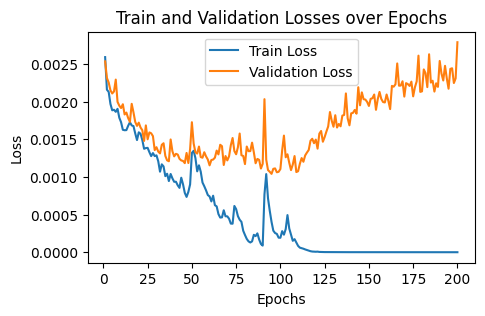

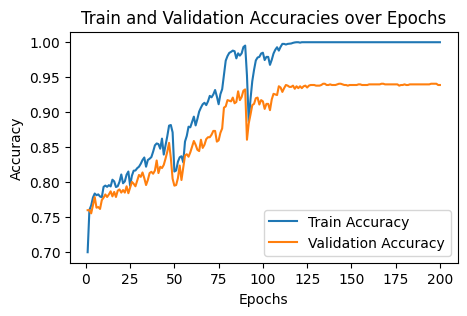

In [24]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH)
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH)

In [23]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/4000_GRU_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {134}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

100%|██████████| 5/5 [00:00<00:00, 498.40it/s]

Best epoch: 134
macro F1 Score: 0.9295652673730194
AUROC: 0.9721242286762263
Accuracy: 0.940754039497307


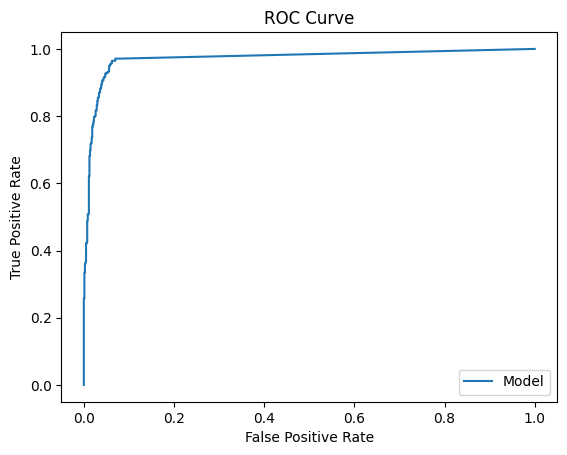

In [28]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)

# Explain (shapely value)

In [24]:
# Processing Hangul data
plt.rcParams['font.size'] = 10
# fonts
plt.rcParams['font.family'] ='NanumGothicCoding'

matplotlib.rcParams['axes.unicode_minus'] =False

In [47]:
import shap
# 기준이 될 background와 model에 넣을 input을 정의해준다
background = test_loader.dataset.x_data[:100]
input = test_loader.dataset.x_data[35:45].to(device)

In [48]:
outputs = model(input)
_, predicted = torch.max(outputs, 1)
predicted

tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')

In [49]:
torch.backends.cudnn.enabled = False
# shap의 explainer와 input을 explainer에 넣고 shap value를 구함
e = shap.GradientExplainer(model, background.to(device))
shap_values = e.shap_values(input.to(device))

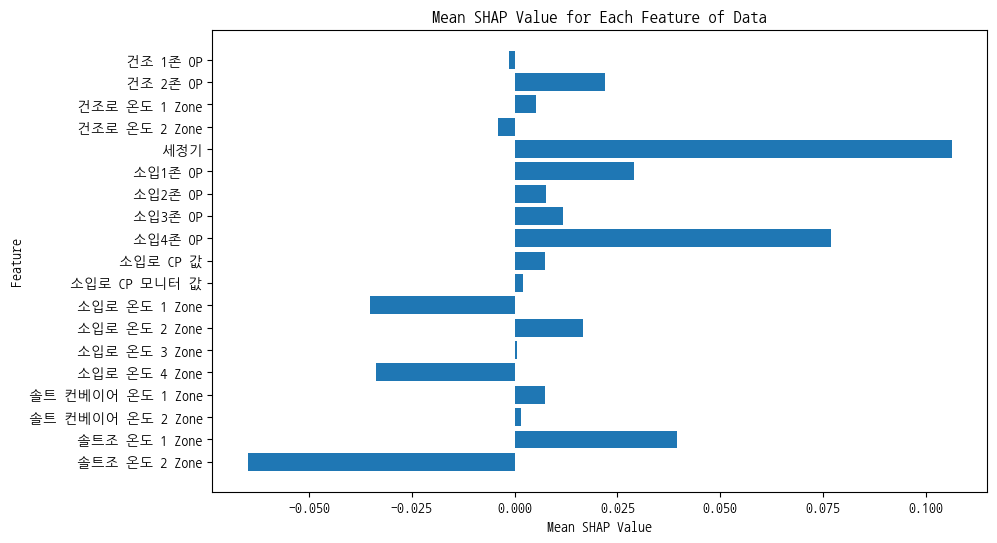

In [50]:
# 첫번째[0]은 분류에서의 0,1 이고 두번째[0]은 보고싶은 데이터의 shap value의 몇번째에 관한 것이다.
shap_value = shap_values[1][2]

# 각 feature에 대해 60개의 값들의 평균 계산
feature_means = np.mean(shap_value, axis=0)

# 특성의 이름
features = ['건조 1존 OP', '건조 2존 OP', '건조로 온도 1 Zone', '건조로 온도 2 Zone', '세정기',
            '소입1존 OP', '소입2존 OP', '소입3존 OP', '소입4존 OP', '소입로 CP 값', '소입로 CP 모니터 값',
            '소입로 온도 1 Zone', '소입로 온도 2 Zone', '소입로 온도 3 Zone', '소입로 온도 4 Zone',
            '솔트 컨베이어 온도 1 Zone', '솔트 컨베이어 온도 2 Zone', '솔트조 온도 1 Zone',
            '솔트조 온도 2 Zone']

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(features, feature_means)  # y값을 특성의 이름으로 설정
plt.xlabel('Mean SHAP Value')
plt.ylabel('Feature')
plt.title('Mean SHAP Value for Each Feature of Data')
plt.gca().invert_yaxis()  # y축을 뒤집어, 첫 번째 특성이 아래에 위치하게 합니다.
plt.show()

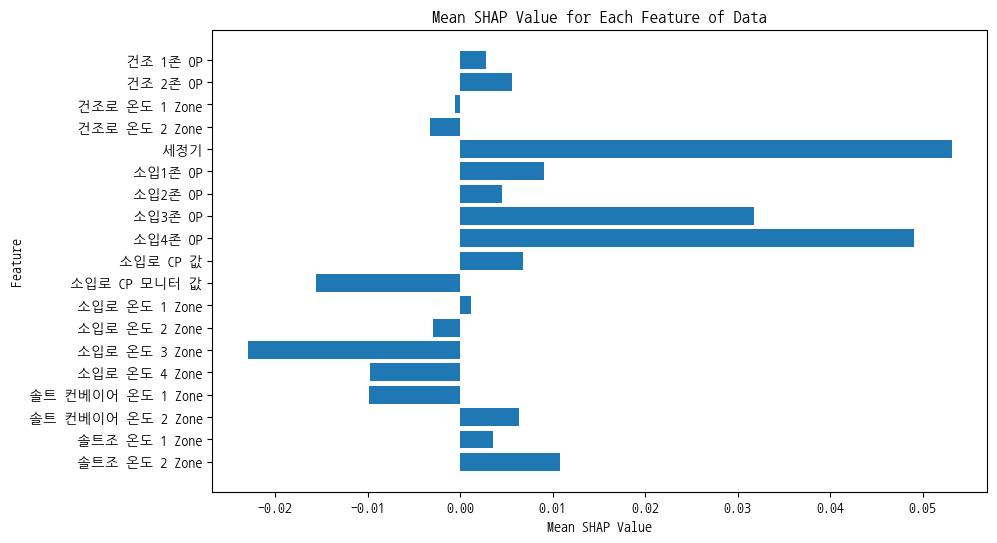

In [51]:
# 첫번째[0]은 분류에서의 0,1 이고 두번째[0]은 보고싶은 데이터의 shap value의 몇번째에 관한 것이다.
shap_value = shap_values[1][6]

# 각 feature에 대해 60개의 값들의 평균 계산
feature_means = np.mean(shap_value, axis=0)

# 특성의 이름
features = ['건조 1존 OP', '건조 2존 OP', '건조로 온도 1 Zone', '건조로 온도 2 Zone', '세정기',
            '소입1존 OP', '소입2존 OP', '소입3존 OP', '소입4존 OP', '소입로 CP 값', '소입로 CP 모니터 값',
            '소입로 온도 1 Zone', '소입로 온도 2 Zone', '소입로 온도 3 Zone', '소입로 온도 4 Zone',
            '솔트 컨베이어 온도 1 Zone', '솔트 컨베이어 온도 2 Zone', '솔트조 온도 1 Zone',
            '솔트조 온도 2 Zone']

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(features, feature_means)  # y값을 특성의 이름으로 설정
plt.xlabel('Mean SHAP Value')
plt.ylabel('Feature')
plt.title('Mean SHAP Value for Each Feature of Data')
plt.gca().invert_yaxis()  # y축을 뒤집어, 첫 번째 특성이 아래에 위치하게 합니다.
plt.show()

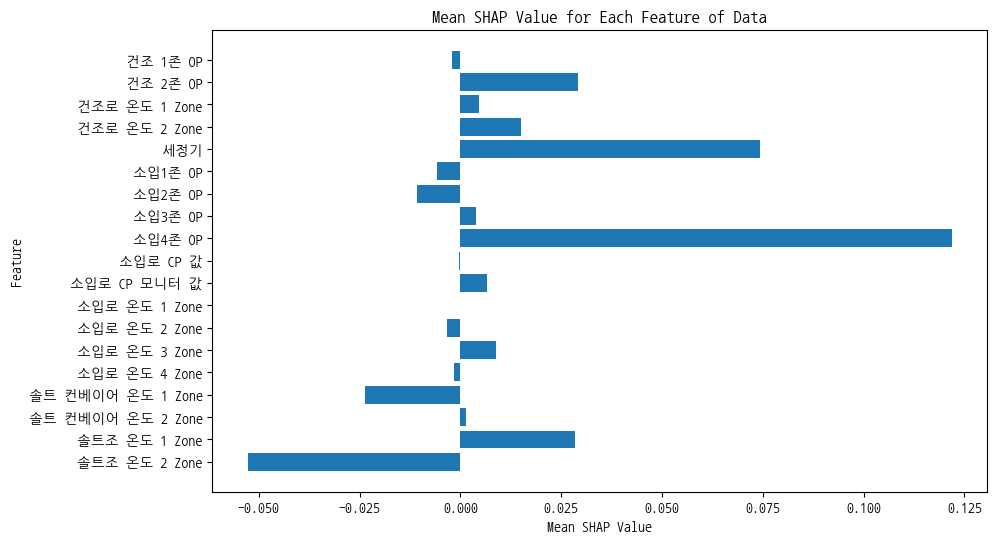

In [52]:
# 첫번째[0]은 분류에서의 0,1 이고 두번째[0]은 보고싶은 데이터의 shap value의 몇번째에 관한 것이다.
shap_value = shap_values[1][7]

# 각 feature에 대해 60개의 값들의 평균 계산
feature_means = np.mean(shap_value, axis=0)

# 특성의 이름
features = ['건조 1존 OP', '건조 2존 OP', '건조로 온도 1 Zone', '건조로 온도 2 Zone', '세정기',
            '소입1존 OP', '소입2존 OP', '소입3존 OP', '소입4존 OP', '소입로 CP 값', '소입로 CP 모니터 값',
            '소입로 온도 1 Zone', '소입로 온도 2 Zone', '소입로 온도 3 Zone', '소입로 온도 4 Zone',
            '솔트 컨베이어 온도 1 Zone', '솔트 컨베이어 온도 2 Zone', '솔트조 온도 1 Zone',
            '솔트조 온도 2 Zone']

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(features, feature_means)  # y값을 특성의 이름으로 설정
plt.xlabel('Mean SHAP Value')
plt.ylabel('Feature')
plt.title('Mean SHAP Value for Each Feature of Data')
plt.gca().invert_yaxis()  # y축을 뒤집어, 첫 번째 특성이 아래에 위치하게 합니다.
plt.show()